# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline

In [3]:
from copy import deepcopy
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from PIL import Image
import sklearn
from icecream import ic

In [4]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
from datasets import GtsrbModule

In [6]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.datamodules import STL10DataModule

In [7]:
from models import ResnetModule

In [8]:
from dropblock import DropBlock2D, LinearScheduler

In [9]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.detectors import KDEClassifier
from ls_ood_detect_cea.metrics import get_ood_detector_results, plot_roc_ood_detector

In [10]:
from ls_ood_detect_cea.metrics import get_hz_detector_results

In [11]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.detectors import KDEClassifier, DetectorKDE
from ls_ood_detect_cea.score import get_hz_scores
from ls_ood_detect_cea.metrics import get_hz_detector_results
from ls_ood_detect_cea.metrics import get_ood_detector_results
from ls_ood_detect_cea.metrics import plot_roc_ood_detector
from ls_ood_detect_cea.metrics import plot_auprc_ood_detector
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_ds_split
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_transform

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Paths

Datasets paths:

In [13]:
gtsrb_dataset_path = "/media/farnez/Data/DATASETS/gtsrb-data/"
cifar10_data_path = "/media/farnez/Data/DATASETS/cifar-10/"
stl10_data_path = "/media/farnez/Data/DATASETS/stl-10/"

Experiments path:

In [14]:
exp_path = "/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/"

Resnet Classification Model Number & checkpoint:

In [15]:
exp_model_name = "resnet18_model_1"

In [16]:
gtsrb_resnet18_model_path = exp_path + exp_model_name + "/model/epoch=1101-step=154280.ckpt"
gtsrb_resnet18_model_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/resnet18_model_1/model/epoch=1101-step=154280.ckpt'

**Baseline models path:**

In [17]:
baseline_methods_path = "baseline_methods/"

In [18]:
baseline_model_mcd_path = "models/resnet18_mcd/"
baseline_model_det_path = "models/resnet18_det/"

**ResNet18 MCD only Classifier**

- No DropBlock2D
- Only Dropout layer

In [19]:
gtsrb_mcd_model_path = exp_path + baseline_methods_path + baseline_model_mcd_path + "last.ckpt"
gtsrb_mcd_model_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/baseline_methods/models/resnet18_mcd/last.ckpt'

**Deterministic ResNet18 Classifier**
- No DropBlock2D neither Dropout

In [20]:
gtsrb_det_model_path = exp_path + baseline_methods_path + baseline_model_det_path + "last.ckpt"
gtsrb_det_model_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/baseline_methods/models/resnet18_det/last.ckpt'

Detection Baselines Samples Paths:

In [21]:
baselines_samples_path = "OoD_detection_baselines/"

In [22]:
predicted_uncertainty_path = exp_path + baseline_methods_path + baselines_samples_path + "predicted_uncertainty/"
predicted_uncertainty_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/baseline_methods/OoD_detection_baselines/predicted_uncertainty/'

In [23]:
msp_score_path = exp_path + baseline_methods_path + baselines_samples_path + "msp_score/"
msp_score_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/baseline_methods/OoD_detection_baselines/msp_score/'

In [24]:
energy_score_path = exp_path + baseline_methods_path + baselines_samples_path + "energy_score/"
energy_score_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/baseline_methods/OoD_detection_baselines/energy_score/'

In [25]:
m_dist_score_path = exp_path + baseline_methods_path + baselines_samples_path + "mahalanobis_dist_score/"
m_dist_score_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/baseline_methods/OoD_detection_baselines/mahalanobis_dist_score/'

In [26]:
knn_dist_score_path = exp_path + baseline_methods_path + baselines_samples_path + "knn_dist_score/"
knn_dist_score_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/baseline_methods/OoD_detection_baselines/knn_dist_score/'

# Datasets

## GTSRB-Normal

In [27]:
gtsrb_normal_dm = GtsrbModule(img_size=(128, 128), data_path=gtsrb_dataset_path, batch_size=1, shuffle=False)

In [28]:
gtsrb_normal_dm.setup(stage='fit')
gtsrb_normal_dm.setup(stage='validate')
gtsrb_normal_dm.setup(stage='test')

In [29]:
gtsrb_ds_len = len(gtsrb_normal_dm.ds_gtsrb_train)
indices_train_dl = list(range(gtsrb_ds_len))
samples_size = 0.2 # of the dataset

random.seed(9290)
random.shuffle(indices_train_dl)

split = int(np.floor(gtsrb_ds_len * samples_size))
samples_idx = indices_train_dl[:split]
ic(len(samples_idx));

train_sampler = SubsetRandomSampler(samples_idx)

gtsrb_normal_dm.shuffle = False
gtsrb_normal_dm.ds_gtsrb_train_sampler = train_sampler

ic| len(samples_idx): 7120


In [30]:
gtsrb_normal_train_loader = gtsrb_normal_dm.train_dataloader()
gtsrb_normal_valid_loader = gtsrb_normal_dm.val_dataloader()
gtsrb_normal_test_loader = gtsrb_normal_dm.test_dataloader()
ic(len(gtsrb_normal_train_loader));
ic(len(gtsrb_normal_valid_loader));
ic(len(gtsrb_normal_test_loader));

ic| len(gtsrb_normal_train_loader): 7120
ic| len(gtsrb_normal_valid_loader): 3609
ic| len(gtsrb_normal_test_loader): 1273


In [31]:
dataiter = iter(gtsrb_normal_train_loader)

No passing


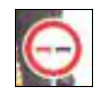

In [32]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
print(gtsrb_normal_dm.idx2label[lbl_np.item()])
gtsrb_normal_dm.unprocess_image(samp[0], plot=True)

## GTSRB-Anomalies

In [33]:
gtsrb_anomal_dm = GtsrbModule(img_size=(128, 128), data_path=gtsrb_dataset_path, batch_size=1, anomaly_transforms=True, shuffle=True)

In [34]:
gtsrb_anomal_dm.setup(stage='fit')
gtsrb_anomal_dm.setup(stage='validate')
gtsrb_anomal_dm.setup(stage='test')

In [35]:
gtsrb_anomal_train_loader = gtsrb_anomal_dm.train_dataloader()
gtsrb_anomal_valid_loader = gtsrb_anomal_dm.val_dataloader()
gtsrb_anomal_test_loader = gtsrb_anomal_dm.test_dataloader()
ic(len(gtsrb_anomal_train_loader));
ic(len(gtsrb_anomal_valid_loader));
ic(len(gtsrb_anomal_test_loader));

ic| len(gtsrb_anomal_train_loader): 35600
ic| len(gtsrb_anomal_valid_loader): 3609
ic| len(gtsrb_anomal_test_loader): 1273


In [36]:
dataiter_anomal = iter(gtsrb_anomal_train_loader)

Stop


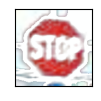

In [37]:
samp, lbl = dataiter_anomal.next()
lbl_np = lbl[0].cpu().numpy()
print(gtsrb_anomal_dm.idx2label[lbl_np.item()])
gtsrb_anomal_dm.unprocess_image(samp[0], plot=True)

## CIFAR-10 OoD

In [38]:
cifar10_dm = CIFAR10DataModule(data_dir=cifar10_data_path,
                               val_split=0.2,
                               num_workers=10,
                               normalize=True,
                               batch_size=1,
                               seed=10,
                               drop_last=True,
                               shuffle=True)

cifar10_transforms = transform_lib.Compose([
    transform_lib.Resize((128, 128)),
    transform_lib.ToTensor(),
    transform_lib.Normalize(
        mean=[0.3337, 0.3064, 0.3171],
        std=[0.2672, 0.2564, 0.2629]
    )
])

cifar10_dm.train_transforms = cifar10_transforms
cifar10_dm.test_transforms = cifar10_transforms
cifar10_dm.val_transforms  = cifar10_transforms

In [39]:
# cifar10_dm.prepare_data()

In [40]:
cifar10_dm.setup(stage='fit')
cifar10_dm.setup(stage='test')

In [41]:
cifar10_train_loader = cifar10_dm.train_dataloader()
cifar10_valid_loader = cifar10_dm.val_dataloader()
cifar10_test_loader = cifar10_dm.test_dataloader()
ic(len(cifar10_train_loader));
ic(len(cifar10_valid_loader));
ic(len(cifar10_test_loader));

ic| len(cifar10_train_loader): 40000
ic| len(cifar10_valid_loader): 10000
ic| len(cifar10_test_loader): 10000


In [42]:
def unprocess_cifar10_image(im,
                            norm_mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                            norm_std=[x / 255.0 for x in [63.0, 62.1, 66.7]], 
                            plot=False):
    # im = im.squeeze().numpy().transpose((1, 2, 0))
    norm_mean = np.array(norm_mean)
    norm_std = np.array(norm_std)
    im = im.squeeze().numpy().transpose((1, 2, 0))
    im = norm_std * im + norm_mean
    im = np.clip(im, 0, 1)
    im = im * 255
    im = Image.fromarray(im.astype(np.uint8))

    if plot:
        plt.rcParams['figure.figsize'] = [2.54/2.54, 2.54/2.54]
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        return im

In [43]:
dataiter = iter(cifar10_train_loader)

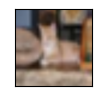

In [44]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
unprocess_cifar10_image(samp[0], norm_mean=[0.3337, 0.3064, 0.3171], norm_std=[0.2672, 0.2564, 0.2629], plot=True)

## STL-10 OoD

In [45]:
stl10_dm = STL10DataModule(data_dir=stl10_data_path,
                           train_val_split=3000,
                           num_workers=10,
                           batch_size=1,
                           seed=10,
                           drop_last=True,
                           shuffle=True)

stl10_transforms = transform_lib.Compose([
    transform_lib.Resize((128, 128)),
    transform_lib.ToTensor(),
    transform_lib.Normalize(
        mean=(0.3337, 0.3064, 0.3171),
        std=(0.2672, 0.2564, 0.2629)
    )
])

stl10_dm.train_transforms = stl10_transforms
stl10_dm.test_transforms = stl10_transforms
stl10_dm.val_transforms  = stl10_transforms

In [46]:
# stl10_dm.prepare_data()

In [47]:
stl10_train_loader = stl10_dm.train_dataloader_labeled()
stl10_valid_loader = stl10_dm.val_dataloader_labeled()
stl10_test_loader = stl10_dm.test_dataloader()
ic(len(stl10_train_loader));
ic(len(stl10_valid_loader));
ic(len(stl10_test_loader));

ic| len(stl10_train_loader): 2000
ic| len(stl10_valid_loader): 3000
ic| len(stl10_test_loader): 8000


In [48]:
def unprocess_stl10_image(im,
                          norm_mean=[0.43, 0.42, 0.39],
                          norm_std=[0.27, 0.26, 0.27], 
                          plot=False):
    # im = im.squeeze().numpy().transpose((1, 2, 0))
    norm_mean = np.array(norm_mean)
    norm_std = np.array(norm_std)
    im = im.squeeze().numpy().transpose((1, 2, 0))
    im = norm_std * im + norm_mean
    im = np.clip(im, 0, 1)
    im = im * 255
    im = Image.fromarray(im.astype(np.uint8))

    if plot:
        plt.rcParams['figure.figsize'] = [2.54/2.54, 2.54/2.54]
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        return im

In [49]:
dataiter = iter(stl10_train_loader)

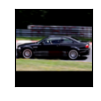

In [50]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
unprocess_stl10_image(samp[0], norm_mean=[0.3337, 0.3064, 0.3171], norm_std=[0.2672, 0.2564, 0.2629], plot=True)

# Dataset Distribution Shift Uncertainty Latent Representations - MCD

GTSRB Anomal Detection

In [61]:
m1_gtsrb_anomal_auroc =  torch.tensor([[0.8130, 0.8147, 0.8127]])
m1_gtsrb_anomal_fpr95 =  torch.tensor([[0.6794, 0.6934, 0.7106]])
m1_gtsrb_anomal_aupr =  torch.tensor([[0.8015, 0.7988, 0.8023]])

In [62]:
std_mean_gtsrb_anomal_auroc = torch.std_mean(m1_gtsrb_anomal_auroc, unbiased=True)
std_mean_gtsrb_anomal_fpr95 = torch.std_mean(m1_gtsrb_anomal_fpr95, unbiased=True)
std_mean_gtsrb_anomal_aupr = torch.std_mean(m1_gtsrb_anomal_aupr, unbiased=True)
ic(std_mean_gtsrb_anomal_auroc);
ic(std_mean_gtsrb_anomal_fpr95);
ic(std_mean_gtsrb_anomal_aupr);

ic| std_mean_gtsrb_anomal_auroc: (tensor(0.0011), tensor(0.8135))


ic| std_mean_gtsrb_anomal_fpr95: (tensor(0.0156), tensor(0.6945))
ic| std_mean_gtsrb_anomal_aupr: (tensor(0.0018), tensor(0.8009))


CIFAR10 Detection

In [63]:
m1_cifar10_auroc =  torch.tensor([[0.9673, 0.9662, 0.9665]])
m1_cifar10_fpr95 =  torch.tensor([[0.1992, 0.2238, 0.2174]])
m1_cifar10_aupr =  torch.tensor([[0.9334, 0.9338, 0.9334]])

In [64]:
std_mean_cifar10_auroc = torch.std_mean(m1_cifar10_auroc, unbiased=True)
std_mean_cifar10_fpr95 = torch.std_mean(m1_cifar10_fpr95, unbiased=True)
std_mean_cifar10_aupr = torch.std_mean(m1_cifar10_aupr, unbiased=True)
ic(std_mean_cifar10_auroc);
ic(std_mean_cifar10_fpr95);
ic(std_mean_cifar10_aupr);

ic| std_mean_cifar10_auroc: (tensor(0.0006), tensor(0.9667))
ic| std_mean_cifar10_fpr95: (tensor(0.0128), tensor(0.2135))
ic| std_mean_cifar10_aupr: (

tensor(0.0002), tensor(0.9335))


STL10 Detection

In [65]:
m1_stl10_auroc =  torch.tensor([[0.9845, 0.9836, 0.9843]])
m1_stl10_fpr95 =  torch.tensor([[0.0603, 0.0717, 0.0670]])
m1_stl10_aupr =  torch.tensor([[0.9777, 0.9770, 0.9771]])

In [66]:
std_mean_stl10_auroc = torch.std_mean(m1_stl10_auroc, unbiased=True)
std_mean_stl10_fpr95 = torch.std_mean(m1_stl10_fpr95, unbiased=True)
std_mean_stl10_aupr = torch.std_mean(m1_stl10_aupr, unbiased=True)
ic(std_mean_stl10_auroc);
ic(std_mean_stl10_fpr95);
ic(std_mean_stl10_aupr);

ic| std_mean_stl10_auroc: (tensor(0.0005), tensor(0.9841))
ic| std_mean_stl10_fpr95: (tensor(0.0057), tensor(0.0663))
ic| std_mean_stl10_aupr: (tensor(0.0004), tensor

(0.9773))


# GTSRB ResNet18 Classifier

**ResNet18 MCD only Classifier**

- No DropBlock2D
- Only Dropout layer

In [73]:
gtsrb_mcd_model = ResnetModule.load_from_checkpoint(checkpoint_path=gtsrb_mcd_model_path)

In [ ]:
gtsrb_mcd_model;

In [98]:
gtsrb_mcd_model.eval();

**Deterministic ResNet18 Classifier**
- No DropBlock2D neither Dropout

In [51]:
gtsrb_det_model = ResnetModule.load_from_checkpoint(checkpoint_path=gtsrb_det_model_path)

In [52]:
gtsrb_det_model;

In [53]:
gtsrb_det_model.eval();

# Dataset Distribution Shift Detection Baselines

In [67]:
ic(len(gtsrb_normal_train_loader));
ic(len(gtsrb_normal_valid_loader));
ic(len(gtsrb_normal_test_loader));
ic("========================================")
ic(len(gtsrb_anomal_train_loader));
ic(len(gtsrb_anomal_valid_loader));
ic(len(gtsrb_anomal_test_loader));
ic("========================================")
ic(len(cifar10_train_loader));
ic(len(cifar10_valid_loader));
ic(len(cifar10_test_loader));
ic("========================================")
ic(len(stl10_train_loader));
ic(len(stl10_valid_loader));
ic(len(stl10_test_loader));

ic| len(gtsrb_normal_train_loader): 7120
ic| len(gtsrb_normal_valid_loader): 3609
ic| len(gtsrb_normal_test_loader): 1273
ic| '========================================'
ic| len(gtsrb_anomal_train_loader): 35600
ic| len(gtsrb_anomal_valid_loader): 3609
ic| len(gtsrb_anomal_test_loader): 1273
ic| '========================================'
ic| len(cifar10_train_loader): 40000
ic| len(cifar10_valid_loader): 10000
ic| len(cifar10_test_loader): 10000
ic| '========================================'
ic| len(stl10_train_loader): 2000
ic| len(stl10_valid_loader): 3000
ic| len(stl10_test_loader): 8000


## Predictive Uncertainty

In [100]:
ic("================================");
ic(gtsrb_mcd_model.model.dropout_layer);
ic(gtsrb_mcd_model.model.dropout_layer.p);
ic(gtsrb_mcd_model.model.dropout_layer.training);

ic| '================================'
ic| gtsrb_mcd_model.model.dropout_layer: Dropout(p=0.3, inplace=False)
ic| gtsrb_mcd_model.model.dropout_layer.p: 0.3
ic| gtsrb_mcd_model.model.dropout_layer.training: False


In [101]:
def resnet18_enable_dropout_test(m):
    if type(m) == torch.nn.Dropout:
        m.train()

In [102]:
gtsrb_mcd_model.to(device);
gtsrb_mcd_model.eval(); 
gtsrb_mcd_model.apply(resnet18_enable_dropout_test); # enable dropout

In [103]:
ic("================================");
ic(gtsrb_mcd_model.model.dropout_layer);
ic(gtsrb_mcd_model.model.dropout_layer.p);
ic(gtsrb_mcd_model.model.dropout_layer.training);

ic| '================================'
ic| gtsrb_mcd_model.model.dropout_layer: Dropout(p=0.3, inplace=False)
ic| gtsrb_mcd_model.model.dropout_layer.p: 0.3
ic| 

gtsrb_mcd_model.model.dropout_layer.training: True


In [104]:
def get_mcd_pred_uncertainty_score(dnn_model: torch.nn.Module,
                                   input_dataloader: DataLoader,
                                   mcd_nro_samples: int = 2):
    
    softmax_fn = torch.nn.Softmax(dim=1)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # gtsrb_model.to(device)
    with torch.no_grad():
        # dl_imgs_latent_mcd_samples = []
        # dl_pred_mcd_samples = []
        img_pred_mcd_samples = []
        
        for i, (image, label) in enumerate(input_dataloader):
            image = image.to(device)
            
            for sample in range(mcd_nro_samples):
                pred_img = dnn_model(image)      

                img_pred_mcd_samples.append(pred_img)

            img_pred_mcd_samples_t = torch.cat(img_pred_mcd_samples, dim=0)
            # ic(img_pred_mcd_samples_t.shape)
            
            # compute softmax output - normalized output:
            img_pred_softmax_mcd_samples_t = softmax_fn(img_pred_mcd_samples_t)
            
        dl_pred_mcd_samples = torch.split(img_pred_softmax_mcd_samples_t, mcd_nro_samples)
        # Get dataloader mcd predictions:
        dl_pred_mcd_samples_t = torch.stack(dl_pred_mcd_samples)
        
        # get predictive entropy:
        expect_preds = torch.mean(dl_pred_mcd_samples_t, dim=1)
        pred_h_t = -torch.sum((expect_preds * torch.log(expect_preds)), dim=1)
        # get expected entropy:
        preds_h = -torch.sum(dl_pred_mcd_samples_t * torch.log(dl_pred_mcd_samples_t), dim=-1)
        expected_h_preds_t = torch.mean(preds_h, dim=1)
        # get mutual information:
        mi_t = pred_h_t - expected_h_preds_t
       
    
    return dl_pred_mcd_samples_t, pred_h_t, mi_t


In [105]:
dl_gtsrb_test_preds, dl_gtsrb_test_pred_h, dl_gtsrb_test_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_mcd_model.model, 
                                                                                             input_dataloader=gtsrb_normal_test_loader,
                                                                                             mcd_nro_samples=16)

In [106]:
dl_gtsrb_anomal_test_preds, dl_gtsrb_anomal_test_pred_h, dl_gtsrb_anomal_test_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_mcd_model.model, 
                                                                                                                  input_dataloader=gtsrb_anomal_test_loader,
                                                                                                                  mcd_nro_samples=16)

In [107]:
dl_cifar10_test_preds, dl_cifar10_test_pred_h, dl_cifar10_test_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_mcd_model.model, 
                                                                                                   input_dataloader=cifar10_test_loader,
                                                                                                   mcd_nro_samples=16)

In [108]:
dl_stl10_test_preds, dl_stl10_test_pred_h, dl_stl10_test_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_mcd_model.model, 
                                                                                             input_dataloader=stl10_test_loader,
                                                                                             mcd_nro_samples=16)

In [109]:
dl_gtsrb_valid_preds, dl_gtsrb_valid_pred_h, dl_gtsrb_valid_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_mcd_model.model, 
                                                                                                input_dataloader=gtsrb_normal_valid_loader,
                                                                                                mcd_nro_samples=16)

In [110]:
dl_gtsrb_anomal_valid_preds, dl_gtsrb_anomal_valid_pred_h, dl_gtsrb_anomal_valid_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_mcd_model.model, 
                                                                                                                     input_dataloader=gtsrb_anomal_valid_loader,
                                                                                                                     mcd_nro_samples=16)

In [111]:
dl_cifar10_valid_preds, dl_cifar10_valid_pred_h, dl_cifar10_valid_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_mcd_model.model, 
                                                                                                      input_dataloader=cifar10_valid_loader,
                                                                                                      mcd_nro_samples=16)

In [112]:
dl_stl10_valid_preds, dl_stl10_valid_pred_h, dl_stl10_valid_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_mcd_model.model, 
                                                                                                input_dataloader=stl10_valid_loader,
                                                                                                mcd_nro_samples=16)

In [132]:
torch.save(dl_gtsrb_valid_preds,
           predicted_uncertainty_path + 'dl_gtsrb_valid_preds.pt')
torch.save(dl_gtsrb_valid_pred_h,
           predicted_uncertainty_path + 'dl_gtsrb_valid_pred_h.pt')
torch.save(dl_gtsrb_valid_mi,
           predicted_uncertainty_path + 'dl_gtsrb_valid_mi.pt')


torch.save(dl_gtsrb_anomal_valid_preds,
           predicted_uncertainty_path + 'dl_gtsrb_anomal_valid_preds.pt')
torch.save(dl_gtsrb_anomal_valid_pred_h,
           predicted_uncertainty_path + 'dl_gtsrb_anomal_valid_pred_h.pt')
torch.save(dl_gtsrb_anomal_valid_mi,
           predicted_uncertainty_path + 'dl_gtsrb_anomal_valid_mi.pt')


torch.save(dl_cifar10_valid_preds,
           predicted_uncertainty_path + 'dl_cifar10_valid_preds.pt')
torch.save(dl_cifar10_valid_pred_h,
           predicted_uncertainty_path + 'dl_cifar10_valid_pred_h.pt')
torch.save(dl_cifar10_valid_mi,
           predicted_uncertainty_path + 'dl_cifar10_valid_mi.pt')


torch.save(dl_stl10_valid_preds,
           predicted_uncertainty_path + 'dl_stl10_valid_preds.pt')
torch.save(dl_stl10_valid_pred_h,
           predicted_uncertainty_path + 'dl_stl10_valid_pred_h.pt')
torch.save(dl_stl10_valid_mi,
           predicted_uncertainty_path + 'dl_stl10_valid_mi.pt')

In [133]:
torch.save(dl_gtsrb_test_preds,
           predicted_uncertainty_path + 'dl_gtsrb_test_preds.pt')
torch.save(dl_gtsrb_test_pred_h,
           predicted_uncertainty_path + 'dl_gtsrb_test_pred_h.pt')
torch.save(dl_gtsrb_test_mi,
           predicted_uncertainty_path + 'dl_gtsrb_test_mi.pt')


torch.save(dl_gtsrb_anomal_test_preds,
           predicted_uncertainty_path + 'dl_gtsrb_anomal_test_preds.pt')
torch.save(dl_gtsrb_anomal_test_pred_h,
           predicted_uncertainty_path + 'dl_gtsrb_anomal_test_pred_h.pt')
torch.save(dl_gtsrb_anomal_test_mi,
           predicted_uncertainty_path + 'dl_gtsrb_anomal_test_mi.pt')


torch.save(dl_cifar10_test_preds,
           predicted_uncertainty_path + 'dl_cifar10_test_preds.pt')
torch.save(dl_cifar10_test_pred_h,
           predicted_uncertainty_path + 'dl_cifar10_test_pred_h.pt')
torch.save(dl_cifar10_test_mi,
           predicted_uncertainty_path + 'dl_cifar10_test_mi.pt')


torch.save(dl_stl10_test_preds,
           predicted_uncertainty_path + 'dl_stl10_test_preds.pt')
torch.save(dl_stl10_test_pred_h,
           predicted_uncertainty_path + 'dl_stl10_test_pred_h.pt')
torch.save(dl_stl10_test_mi,
           predicted_uncertainty_path + 'dl_stl10_test_mi.pt')

In [216]:
ic(dl_gtsrb_test_pred_h.shape);
ic(dl_gtsrb_test_mi.shape);
ic("================================================================");
ic(dl_gtsrb_anomal_test_pred_h.shape);
ic(dl_gtsrb_anomal_test_mi.shape);
ic("================================================================");
ic(dl_cifar10_test_pred_h.shape);
ic(dl_cifar10_test_mi.shape);
ic("================================================================");
ic(dl_stl10_test_pred_h.shape);
ic(dl_stl10_test_mi.shape);

ic| dl_gtsrb_test_pred_h.shape: torch.Size([1273])


ic| dl_gtsrb_test_mi.shape: torch.Size([1273])
ic| '================================================================'
ic| dl_gtsrb_anomal_test_pred_h.shape: torch.Size([1273])
ic| dl_gtsrb_anomal_test_mi.shape: torch.Size([1273])
ic| '================================================================'
ic| dl_cifar10_test_pred_h.shape: torch.Size([10000])
ic| dl_cifar10_test_mi.shape: torch.Size([10000])
ic| '================================================================'
ic| dl_stl10_test_pred_h.shape: torch.Size([8000])
ic| dl_stl10_test_mi.shape: torch.Size([8000])


In [134]:
ind_gtsrb_test_pred_h_score = dl_gtsrb_test_pred_h.cpu().numpy()
ind_gtsrb_test_mi_score = dl_gtsrb_test_mi.cpu().numpy()
ic(ind_gtsrb_test_pred_h_score.shape);
ic(ind_gtsrb_test_mi_score.shape);

ood_gtsrb_anomal_test_pred_h_score = dl_gtsrb_anomal_test_pred_h.cpu().numpy()
ood_gtsrb_anomal_test_mi_score = dl_gtsrb_anomal_test_mi.cpu().numpy()
ic(ood_gtsrb_anomal_test_pred_h_score.shape);
ic(ood_gtsrb_anomal_test_mi_score.shape);

ood_cifar10_test_pred_h_score = dl_cifar10_test_pred_h.cpu().numpy()
ood_cifar10_test_mi_score = dl_cifar10_test_mi.cpu().numpy()
ic(ood_cifar10_test_pred_h_score.shape);
ic(ood_cifar10_test_mi_score.shape);

ood_stl10_test_pred_h_score = dl_stl10_test_pred_h.cpu().numpy()
ood_stl10_test_mi_score = dl_stl10_test_mi.cpu().numpy()
ic(ood_stl10_test_pred_h_score.shape);
ic(ood_stl10_test_mi_score.shape);

ic| ind_gtsrb_test_pred_h_score.shape: (1273,)
ic| ind_gtsrb_test_mi_score.shape: (1273,)
ic| ood_gtsrb_anomal_test_pred_h_score.shape: (1273,)


ic| ood_gtsrb_anomal_test_mi_score.shape: (1273,)
ic| ood_cifar10_test_pred_h_score.shape: (10000,)
ic| ood_cifar10_test_mi_score.shape: (10000,)
ic| ood_stl10_test_pred_h_score.shape: (8000,)
ic| ood_stl10_test_mi_score.shape: (8000,)


In [135]:
ind_gtsrb_valid_pred_h_score = dl_gtsrb_valid_pred_h.cpu().numpy()
ind_gtsrb_valid_mi_score = dl_gtsrb_valid_mi.cpu().numpy()
ic(ind_gtsrb_valid_pred_h_score.shape);
ic(ind_gtsrb_valid_mi_score.shape);

ood_gtsrb_anomal_valid_pred_h_score = dl_gtsrb_anomal_valid_pred_h.cpu().numpy()
ood_gtsrb_anomal_valid_mi_score = dl_gtsrb_anomal_valid_mi.cpu().numpy()
ic(ood_gtsrb_anomal_valid_pred_h_score.shape);
ic(ood_gtsrb_anomal_valid_mi_score.shape);

ood_cifar10_valid_pred_h_score = dl_cifar10_valid_pred_h.cpu().numpy()
ood_cifar10_valid_mi_score = dl_cifar10_valid_mi.cpu().numpy()
ic(ood_cifar10_valid_pred_h_score.shape);
ic(ood_cifar10_valid_mi_score.shape);

ood_stl10_valid_pred_h_score = dl_stl10_valid_pred_h.cpu().numpy()
ood_stl10_valid_mi_score = dl_stl10_valid_mi.cpu().numpy()
ic(ood_stl10_valid_pred_h_score.shape);
ic(ood_stl10_valid_mi_score.shape);

ic| ind_gtsrb_valid_pred_h_score.shape: (3609,)
ic| ind_gtsrb_valid_mi_score.shape: (3609,)
ic| ood_gtsrb_anomal_valid_pred_h_score.shape: (3609,)
ic| ood_gtsrb_anomal_valid_mi_score.shape: (3609,)
ic| ood_cifar10_valid_pred_h_score.shape: (10000,)
ic| ood_cifar10_valid_mi_score.shape: (10000,)


ic| ood_stl10_valid_pred_h_score.shape: (3000,)
ic| ood_stl10_valid_mi_score.shape: (3000,)


In [136]:
ind_gtsrb_pred_h_score = np.concatenate((ind_gtsrb_valid_pred_h_score, ind_gtsrb_test_pred_h_score))
ind_gtsrb_pred_mi_score = np.concatenate((ind_gtsrb_valid_mi_score, ind_gtsrb_test_mi_score))

ood_gtsrb_anomal_pred_h_score = np.concatenate((ood_gtsrb_anomal_valid_pred_h_score, ood_gtsrb_anomal_test_pred_h_score))
ood_gtsrb_anomal_pred_mi_score = np.concatenate((ood_gtsrb_anomal_valid_mi_score, ood_gtsrb_anomal_test_mi_score))

ood_cifar10_pred_h_score = np.concatenate((ood_cifar10_valid_pred_h_score, ood_cifar10_test_pred_h_score))
ood_cifar10_pred_mi_score = np.concatenate((ood_cifar10_valid_mi_score, ood_cifar10_test_mi_score))

ood_stl10_pred_h_score = np.concatenate((ood_stl10_valid_pred_h_score, ood_stl10_test_pred_h_score))
ood_stl10_pred_mi_score = np.concatenate((ood_stl10_valid_mi_score, ood_stl10_test_mi_score))


### Plot Score Values Predictive Entropy

In [137]:
df_pred_h_scores_gtsrb = pd.DataFrame(ind_gtsrb_pred_h_score, columns=["Predictive H score"])
df_pred_h_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_pred_h_score, columns=["Predictive H score"])
df_pred_h_scores_stl10 = pd.DataFrame(ood_stl10_pred_h_score, columns=["Predictive H score"])
df_pred_h_scores_cifar10 = pd.DataFrame(ood_cifar10_pred_h_score, columns=["Predictive H score"])

df_pred_h_scores_gtsrb.insert(0, "Dataset", "")
df_pred_h_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_pred_h_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_pred_h_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_pred_h_scores_stl10.insert(0, "Dataset", "")
df_pred_h_scores_stl10.loc[:, "Dataset"] = "stl10"

df_pred_h_scores_cifar10.insert(0, "Dataset", "")
df_pred_h_scores_cifar10.loc[:, "Dataset"] = "cifar10"

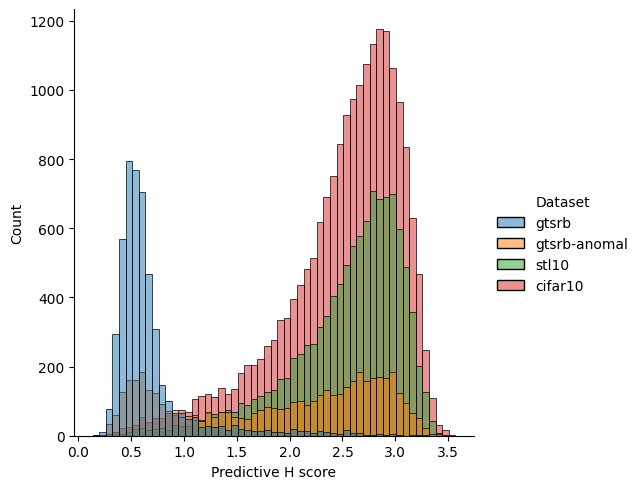

In [138]:
df_pred_h_scores = pd.concat([df_pred_h_scores_gtsrb,
                              df_pred_h_scores_gtsrb_anomal,
                              df_pred_h_scores_stl10,
                              df_pred_h_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive H score", hue="Dataset", kind="hist", fill=True)
plt.show()

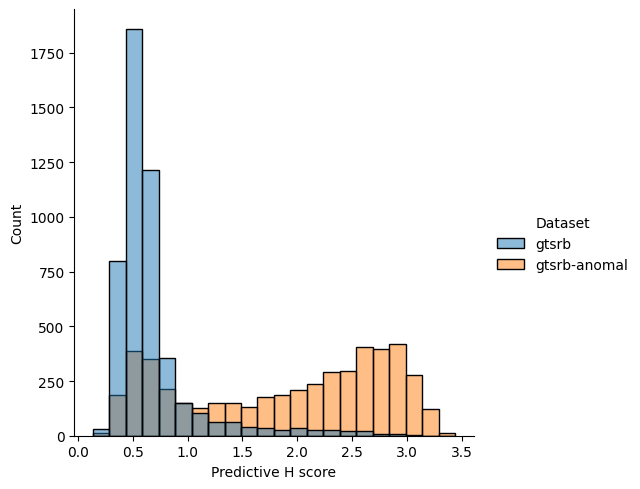

In [139]:
df_pred_h_scores = pd.concat([df_pred_h_scores_gtsrb,
                              df_pred_h_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive H score", hue="Dataset", kind="hist", fill=True)
plt.show()

### Plot Score values Predictive MI

In [140]:
df_mi_scores_gtsrb = pd.DataFrame(ind_gtsrb_pred_mi_score, columns=["Predictive MI score"])
df_mi_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_pred_mi_score, columns=["Predictive MI score"])
df_mi_scores_stl10 = pd.DataFrame(ood_stl10_pred_mi_score, columns=["Predictive MI score"])
df_mi_scores_cifar10 = pd.DataFrame(ood_cifar10_pred_mi_score, columns=["Predictive MI score"])

df_mi_scores_gtsrb.insert(0, "Dataset", "")
df_mi_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_mi_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_mi_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_mi_scores_stl10.insert(0, "Dataset", "")
df_mi_scores_stl10.loc[:, "Dataset"] = "stl10"

df_mi_scores_cifar10.insert(0, "Dataset", "")
df_mi_scores_cifar10.loc[:, "Dataset"] = "cifar10"

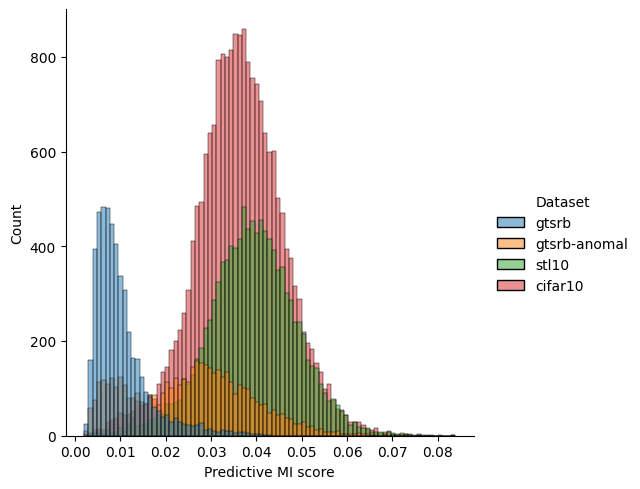

In [141]:
df_pred_mi_scores = pd.concat([df_mi_scores_gtsrb,
                               df_mi_scores_gtsrb_anomal,
                               df_mi_scores_stl10,
                               df_mi_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_mi_scores, x="Predictive MI score", hue="Dataset", kind="hist", fill=True)
plt.show()

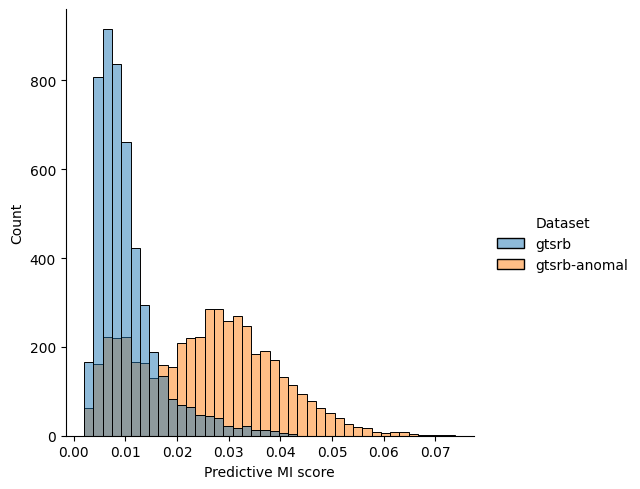

In [143]:
df_pred_mi_scores = pd.concat([df_mi_scores_gtsrb,
                               df_mi_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_pred_mi_scores, x="Predictive MI score", hue="Dataset", kind="hist", fill=True)
plt.show()

### Plot Score Values Predictive Entropy (test split)

In [144]:
df_pred_h_scores_gtsrb = pd.DataFrame(ind_gtsrb_test_pred_h_score, columns=["Predictive H score"])
df_pred_h_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_test_pred_h_score, columns=["Predictive H score"])
df_pred_h_scores_stl10 = pd.DataFrame(ood_stl10_test_pred_h_score, columns=["Predictive H score"])
df_pred_h_scores_cifar10 = pd.DataFrame(ood_cifar10_test_pred_h_score, columns=["Predictive H score"])

df_pred_h_scores_gtsrb.insert(0, "Dataset", "")
df_pred_h_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_pred_h_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_pred_h_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_pred_h_scores_stl10.insert(0, "Dataset", "")
df_pred_h_scores_stl10.loc[:, "Dataset"] = "stl10"

df_pred_h_scores_cifar10.insert(0, "Dataset", "")
df_pred_h_scores_cifar10.loc[:, "Dataset"] = "cifar10"

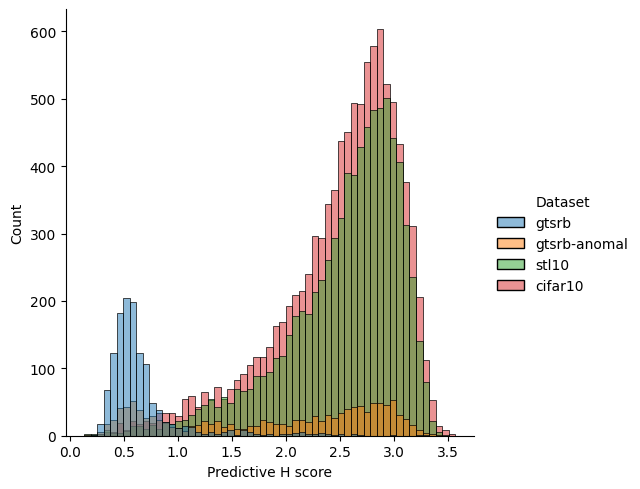

In [145]:
df_pred_h_scores = pd.concat([df_pred_h_scores_gtsrb,
                              df_pred_h_scores_gtsrb_anomal,
                              df_pred_h_scores_stl10,
                              df_pred_h_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive H score", hue="Dataset", kind="hist", fill=True)
plt.show()

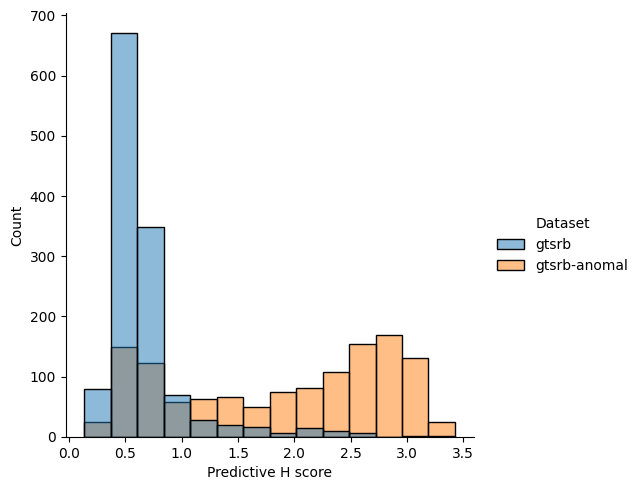

In [146]:
df_pred_h_scores = pd.concat([df_pred_h_scores_gtsrb,
                              df_pred_h_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive H score", hue="Dataset", kind="hist", fill=True)
plt.show()

### Plot Score values Predictive MI (test split)

In [147]:
df_mi_scores_gtsrb = pd.DataFrame(ind_gtsrb_test_mi_score, columns=["Predictive MI score"])
df_mi_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_test_mi_score, columns=["Predictive MI score"])
df_mi_scores_stl10 = pd.DataFrame(ood_stl10_test_mi_score, columns=["Predictive MI score"])
df_mi_scores_cifar10 = pd.DataFrame(ood_cifar10_test_mi_score, columns=["Predictive MI score"])

df_mi_scores_gtsrb.insert(0, "Dataset", "")
df_mi_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_mi_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_mi_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_mi_scores_stl10.insert(0, "Dataset", "")
df_mi_scores_stl10.loc[:, "Dataset"] = "stl10"

df_mi_scores_cifar10.insert(0, "Dataset", "")
df_mi_scores_cifar10.loc[:, "Dataset"] = "cifar10"

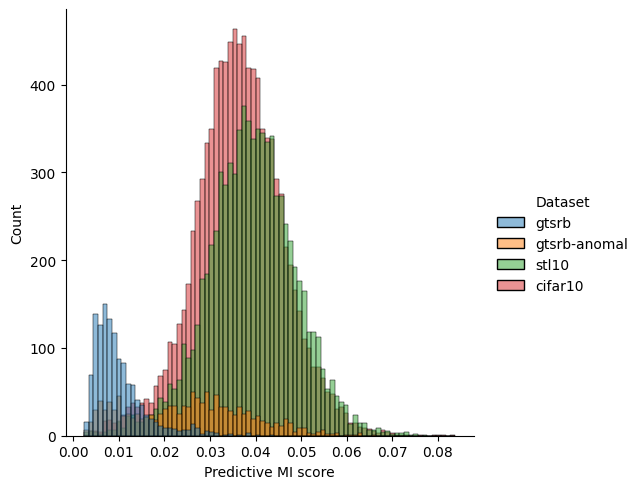

In [148]:
df_pred_mi_scores = pd.concat([df_mi_scores_gtsrb,
                               df_mi_scores_gtsrb_anomal,
                               df_mi_scores_stl10,
                               df_mi_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_mi_scores, x="Predictive MI score", hue="Dataset", kind="hist", fill=True)
plt.show()

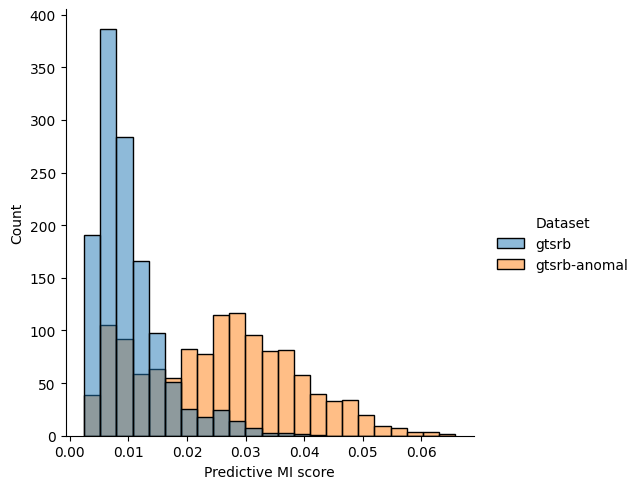

In [149]:
df_pred_mi_scores = pd.concat([df_mi_scores_gtsrb,
                               df_mi_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_pred_mi_scores, x="Predictive MI score", hue="Dataset", kind="hist", fill=True)
plt.show()

### GTSRB vs GTSRB-Anomalies

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [150]:
print("Test InD shape", ind_gtsrb_pred_h_score.shape);
print("Test OoD shape", ood_gtsrb_anomal_pred_h_score.shape);

results_pred_h_gtsrb_anomaly_test = get_hz_detector_results(detect_exp_name="predictive h: gtsrb vs. gtsrb_anomaly",
                                                            ind_samples_scores=-ind_gtsrb_pred_h_score,
                                                            ood_samples_scores=-ood_gtsrb_anomal_pred_h_score)

Test InD shape (4882,)
Test OoD shape (4882,)
AUROC: 0.8634
FPR95: 0.3611
AUPR: 0.7955


In [151]:
print("Test InD shape", ind_gtsrb_pred_mi_score.shape);
print("Test OoD shape", ood_gtsrb_anomal_pred_mi_score.shape);

results_pred_mi_gtsrb_anomaly_test = get_hz_detector_results(detect_exp_name="predictive mi: gtsrb vs. gtsrb_anomaly",
                                                             ind_samples_scores=-ind_gtsrb_pred_mi_score,
                                                             ood_samples_scores=-ood_gtsrb_anomal_pred_mi_score)

Test InD shape (4882,)
Test OoD shape (4882,)
AUROC: 0.8457
FPR95: 0.4222
AUPR: 0.7803


### GTSRB vs CIFAR-10

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [152]:
print("Test InD shape", ind_gtsrb_pred_h_score.shape);
print("Test OoD shape", ood_cifar10_pred_h_score.shape);

results_pred_h_cifar10_test = get_hz_detector_results(detect_exp_name="predictive h: gtsrb vs. cifar10",
                                                      ind_samples_scores=-ind_gtsrb_pred_h_score,
                                                      ood_samples_scores=-ood_cifar10_pred_h_score)

Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.9798
FPR95: 0.0732
AUPR: 0.9263


In [153]:
print("Test InD shape", ind_gtsrb_pred_mi_score.shape);
print("Test OoD shape", ood_cifar10_pred_mi_score.shape);

results_pred_mi_cifar10_test = get_hz_detector_results(detect_exp_name="predictive mi: gtsrb vs. cifar10",
                                                       ind_samples_scores=-ind_gtsrb_pred_mi_score,
                                                       ood_samples_scores=-ood_cifar10_pred_mi_score)

Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.9787
FPR95: 0.0803
AUPR: 0.9279


### GTSRB vs STL-10

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [154]:
print("Test InD shape", ind_gtsrb_pred_h_score.shape);
print("Test OoD shape", ood_stl10_pred_h_score.shape);

results_pred_h_stl10_test = get_hz_detector_results(detect_exp_name="predictive h: gtsrb vs. stl10",
                                                      ind_samples_scores=-ind_gtsrb_pred_h_score,
                                                      ood_samples_scores=-ood_stl10_pred_h_score)

Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.9814
FPR95: 0.0628
AUPR: 0.9517


In [155]:
print("Test InD shape", ind_gtsrb_pred_mi_score.shape);
print("Test OoD shape", ood_stl10_pred_mi_score.shape);

results_pred_mi_stl10_test = get_hz_detector_results(detect_exp_name="predictive mi: gtsrb vs. stl10",
                                                       ind_samples_scores=-ind_gtsrb_pred_mi_score,
                                                       ood_samples_scores=-ood_stl10_pred_mi_score)

Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.9842
FPR95: 0.0562
AUPR: 0.9601


## MSP Score

In [79]:
gtsrb_det_model.to(device);
gtsrb_det_model.eval(); 

In [80]:
def get_msp_score(dnn_model: torch.nn.Module,
                  input_dataloader: DataLoader):
    
    softmax_fn = torch.nn.Softmax(dim=1)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # gtsrb_model.to(device)
    dl_preds = []
    dl_preds_msp_scores = []

    with torch.no_grad():
        
        for i, (image, label) in enumerate(input_dataloader):
            image = image.to(device)
            pred_logits = dnn_model(image)
                                    
            pred_score = torch.max(softmax_fn(pred_logits), dim=1)
            # ic(pred_score.shape)
            # get the max values:
            dl_preds_msp_scores.append(pred_score[0])
        
        dl_preds_msp_scores_t = torch.cat(dl_preds_msp_scores, dim=0)
        # ic(dl_preds_msp_scores_t.shape)
        # pred = np.max(softmax_fn(pred_logits).detach().cpu().numpy(), axis=1)
        dl_preds_msp_scores = dl_preds_msp_scores_t.detach().cpu().numpy()
        
    return dl_preds_msp_scores

In [81]:
ind_gtsrb_test_pred_msp_score = get_msp_score(dnn_model=gtsrb_det_model.model, input_dataloader=gtsrb_normal_test_loader)
ood_gtsrb_anomal_test_pred_msp_score = get_msp_score(dnn_model=gtsrb_det_model.model, input_dataloader=gtsrb_anomal_test_loader)
ood_cifar10_test_pred_msp_score = get_msp_score(dnn_model=gtsrb_det_model.model, input_dataloader=cifar10_test_loader)
ood_stl10_test_pred_msp_score = get_msp_score(dnn_model=gtsrb_det_model.model, input_dataloader=stl10_test_loader)

In [82]:
ind_gtsrb_valid_pred_msp_score = get_msp_score(dnn_model=gtsrb_det_model.model, input_dataloader=gtsrb_normal_valid_loader)
ood_gtsrb_anomal_valid_pred_msp_score = get_msp_score(dnn_model=gtsrb_det_model.model, input_dataloader=gtsrb_anomal_valid_loader)
ood_cifar10_valid_pred_msp_score = get_msp_score(dnn_model=gtsrb_det_model.model, input_dataloader=cifar10_valid_loader)
ood_stl10_valid_pred_msp_score = get_msp_score(dnn_model=gtsrb_det_model.model, input_dataloader=stl10_valid_loader)

In [83]:
ind_gtsrb_pred_msp_score = np.concatenate((ind_gtsrb_valid_pred_msp_score, ind_gtsrb_test_pred_msp_score))
ood_gtsrb_anomal_pred_msp_score = np.concatenate((ood_gtsrb_anomal_valid_pred_msp_score, ood_gtsrb_anomal_test_pred_msp_score))
ood_cifar10_pred_msp_score = np.concatenate((ood_cifar10_valid_pred_msp_score, ood_cifar10_test_pred_msp_score))
ood_stl10_pred_msp_score = np.concatenate((ood_stl10_valid_pred_msp_score, ood_stl10_test_pred_msp_score))

In [101]:
np.save(msp_score_path + 'ind_gtsrb_pred_msp_score',
        ind_gtsrb_pred_msp_score)

np.save(msp_score_path + 'ood_gtsrb_anomal_pred_msp_score',
        ood_gtsrb_anomal_pred_msp_score)

np.save(msp_score_path + 'ood_cifar10_pred_msp_score',
        ood_cifar10_pred_msp_score)

np.save(msp_score_path + 'ood_stl10_pred_msp_score',
        ood_stl10_pred_msp_score)

### Plot MSP scores

In [86]:
df_pred_msp_scores_gtsrb = pd.DataFrame(ind_gtsrb_pred_msp_score, columns=["Predictive MSP score"])
df_pred_msp_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_pred_msp_score, columns=["Predictive MSP score"])
df_pred_msp_scores_stl10 = pd.DataFrame(ood_stl10_pred_msp_score, columns=["Predictive MSP score"])
df_pred_msp_scores_cifar10 = pd.DataFrame(ood_cifar10_pred_msp_score, columns=["Predictive MSP score"])

df_pred_msp_scores_gtsrb.insert(0, "Dataset", "")
df_pred_msp_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_pred_msp_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_pred_msp_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_pred_msp_scores_stl10.insert(0, "Dataset", "")
df_pred_msp_scores_stl10.loc[:, "Dataset"] = "stl10"

df_pred_msp_scores_cifar10.insert(0, "Dataset", "")
df_pred_msp_scores_cifar10.loc[:, "Dataset"] = "cifar10"

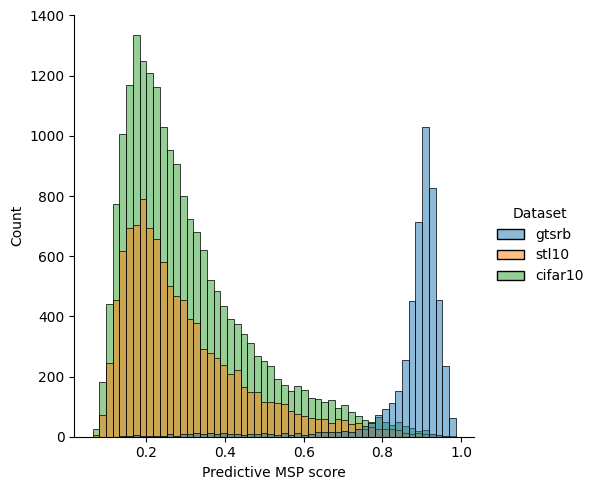

In [92]:
df_pred_h_scores = pd.concat([df_pred_msp_scores_gtsrb,
                            #   df_pred_msp_scores_gtsrb_anomal,
                              df_pred_msp_scores_stl10,
                              df_pred_msp_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive MSP score", hue="Dataset", kind="hist", fill=True)
plt.show()

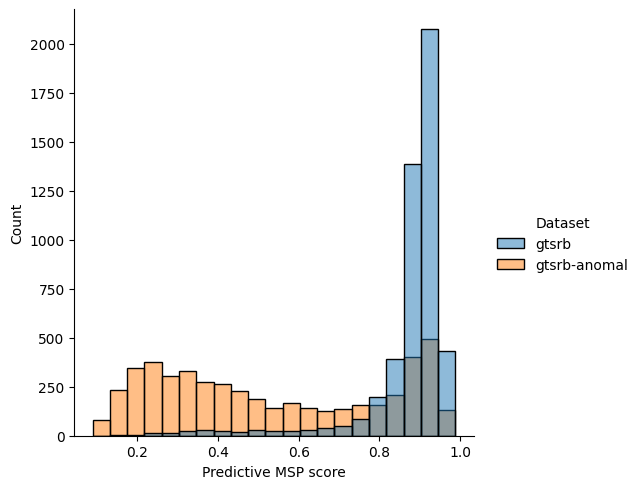

In [88]:
df_pred_h_scores = pd.concat([df_pred_msp_scores_gtsrb,
                              df_pred_msp_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive MSP score", hue="Dataset", kind="hist", fill=True)
plt.show()

### GTSRB vs GTSRB-Anomalies

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [89]:
print("Test InD shape", ind_gtsrb_pred_msp_score.shape);
print("Test OoD shape", ood_gtsrb_anomal_pred_msp_score.shape);

results_pred_msp_gtsrb_anomaly_test = get_hz_detector_results(detect_exp_name="MSP score: gtsrb vs. gtsrb_anomaly",
                                                              ind_samples_scores=ind_gtsrb_pred_msp_score,
                                                              ood_samples_scores=ood_gtsrb_anomal_pred_msp_score)

Test InD shape (4882,)
Test OoD shape (4882,)
AUROC: 0.8492
FPR95: 0.3654
AUPR: 0.7765


### GTSRB vs CIFAR-10

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [90]:
print("Test InD shape", ind_gtsrb_pred_msp_score.shape);
print("Test OoD shape", ood_cifar10_pred_msp_score.shape);

results_pred_msp_cifar10_test = get_hz_detector_results(detect_exp_name="MSP score: gtsrb vs. cifar10",
                                                        ind_samples_scores=ind_gtsrb_pred_msp_score,
                                                        ood_samples_scores=ood_cifar10_pred_msp_score)

Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.9857
FPR95: 0.0463
AUPR: 0.9611


### GTSRB vs STL-10

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [91]:
print("Test InD shape", ind_gtsrb_pred_msp_score.shape);
print("Test OoD shape", ood_stl10_pred_msp_score.shape);

results_pred_msp_stl10_test = get_hz_detector_results(detect_exp_name="MSP score: gtsrb vs. stl10",
                                                      ind_samples_scores=ind_gtsrb_pred_msp_score,
                                                      ood_samples_scores=ood_stl10_pred_msp_score)

Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.9860
FPR95: 0.0432
AUPR: 0.9708


## Energy Score

In [93]:
gtsrb_det_model.to(device);
gtsrb_det_model.eval(); 

In [94]:
def get_energy_score(dnn_model: torch.nn.Module,
                     input_dataloader: DataLoader):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # gtsrb_det_model.to(device)

    dl_preds_energy_scores = []

    with torch.no_grad():
        
        for i, (image, label) in enumerate(input_dataloader):
            image = image.to(device)
            pred_logits = dnn_model(image)
            
            pred_energy_score = torch.logsumexp(pred_logits, dim=1)

            dl_preds_energy_scores.append(pred_energy_score)
        
        dl_preds_energy_scores_t = torch.cat(dl_preds_energy_scores, dim=0)
     
        dl_preds_energy_scores = dl_preds_energy_scores_t.detach().cpu().numpy()
        
    return dl_preds_energy_scores

In [95]:
ind_gtsrb_test_pred_energy_score = get_energy_score(dnn_model=gtsrb_det_model.model, input_dataloader=gtsrb_normal_test_loader)
ood_gtsrb_anomal_test_pred_energy_score = get_energy_score(dnn_model=gtsrb_det_model.model, input_dataloader=gtsrb_anomal_test_loader)
ood_cifar10_test_pred_energy_score = get_energy_score(dnn_model=gtsrb_det_model.model, input_dataloader=cifar10_test_loader)
ood_stl10_test_pred_energy_score = get_energy_score(dnn_model=gtsrb_det_model.model, input_dataloader=stl10_test_loader)

In [96]:
ind_gtsrb_valid_pred_energy_score = get_energy_score(dnn_model=gtsrb_det_model.model, input_dataloader=gtsrb_normal_valid_loader)
ood_gtsrb_anomal_valid_pred_energy_score = get_energy_score(dnn_model=gtsrb_det_model.model, input_dataloader=gtsrb_anomal_valid_loader)
ood_cifar10_valid_pred_energy_score = get_energy_score(dnn_model=gtsrb_det_model.model, input_dataloader=cifar10_valid_loader)
ood_stl10_valid_pred_energy_score = get_energy_score(dnn_model=gtsrb_det_model.model, input_dataloader=stl10_valid_loader)

In [97]:
ind_gtsrb_pred_energy_score = np.concatenate((ind_gtsrb_valid_pred_energy_score, ind_gtsrb_test_pred_energy_score))
ood_gtsrb_anomal_pred_energy_score = np.concatenate((ood_gtsrb_anomal_valid_pred_energy_score, ood_gtsrb_anomal_test_pred_energy_score))
ood_cifar10_pred_energy_score = np.concatenate((ood_cifar10_valid_pred_energy_score, ood_cifar10_test_pred_energy_score))
ood_stl10_pred_energy_score = np.concatenate((ood_stl10_valid_pred_energy_score, ood_stl10_test_pred_energy_score))

In [99]:
np.save(energy_score_path + 'ind_gtsrb_pred_energy_score',
        ind_gtsrb_pred_energy_score)

np.save(energy_score_path + 'ood_gtsrb_anomal_pred_energy_score',
        ood_gtsrb_anomal_pred_energy_score)

np.save(energy_score_path + 'ood_cifar10_pred_energy_score',
        ood_cifar10_pred_energy_score)

np.save(energy_score_path + 'ood_stl10_pred_energy_score',
        ood_stl10_pred_energy_score)

In [132]:
# a = np.load(energy_score_path + 'ind_gtsrb_pred_energy_score.npy')
# a.shape

(4882,)

### Plot Energy scores

In [103]:
df_pred_energy_scores_gtsrb = pd.DataFrame(ind_gtsrb_pred_energy_score, columns=["Predictive Energy score"])
df_pred_energy_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_pred_energy_score, columns=["Predictive Energy score"])
df_pred_energy_scores_stl10 = pd.DataFrame(ood_stl10_pred_energy_score, columns=["Predictive Energy score"])
df_pred_energy_scores_cifar10 = pd.DataFrame(ood_cifar10_pred_energy_score, columns=["Predictive Energy score"])

df_pred_energy_scores_gtsrb.insert(0, "Dataset", "")
df_pred_energy_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_pred_energy_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_pred_energy_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_pred_energy_scores_stl10.insert(0, "Dataset", "")
df_pred_energy_scores_stl10.loc[:, "Dataset"] = "stl10"

df_pred_energy_scores_cifar10.insert(0, "Dataset", "")
df_pred_energy_scores_cifar10.loc[:, "Dataset"] = "cifar10"

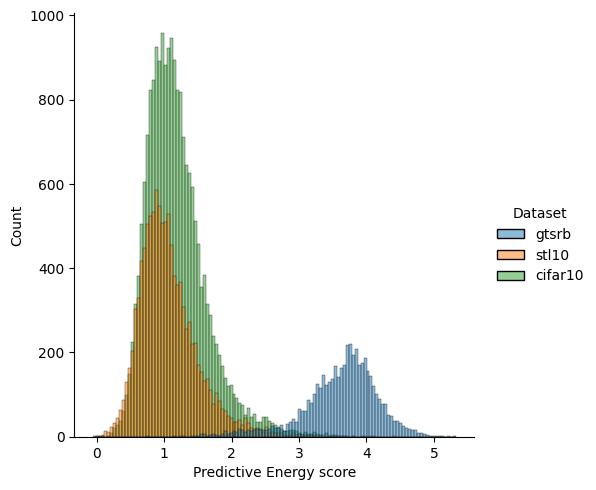

In [105]:
df_pred_h_scores = pd.concat([df_pred_energy_scores_gtsrb,
                            #   df_pred_energy_scores_gtsrb_anomal,
                              df_pred_energy_scores_stl10,
                              df_pred_energy_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive Energy score", hue="Dataset", kind="hist", fill=True)
plt.show()

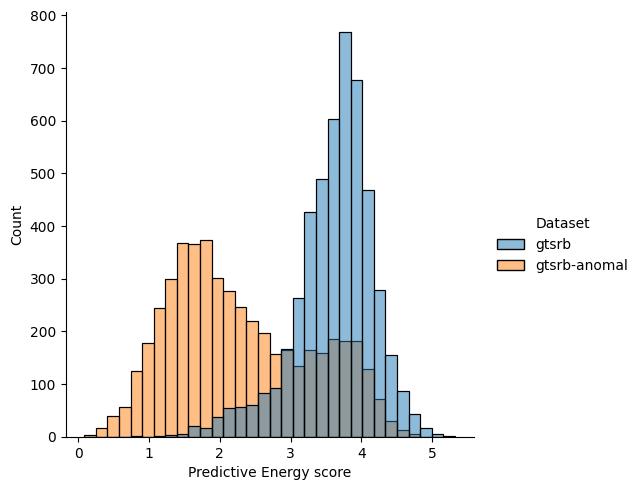

In [106]:
df_pred_h_scores = pd.concat([df_pred_energy_scores_gtsrb,
                              df_pred_energy_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive Energy score", hue="Dataset", kind="hist", fill=True)
plt.show()

### GTSRB vs GTSRB-Anomalies

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [107]:
print("Test InD shape", ind_gtsrb_pred_energy_score.shape);
print("Test OoD shape", ood_gtsrb_anomal_pred_energy_score.shape);

results_pred_energy_gtsrb_anomaly_test = get_hz_detector_results(detect_exp_name="Energy score: gtsrb vs. gtsrb_anomaly",
                                                              ind_samples_scores=ind_gtsrb_pred_energy_score,
                                                              ood_samples_scores=ood_gtsrb_anomal_pred_energy_score)

Test InD shape (4882,)
Test OoD shape (4882,)
AUROC: 0.8547
FPR95: 0.3705
AUPR: 0.8001


### GTSRB vs CIFAR-10

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [110]:
print("Test InD shape", ind_gtsrb_pred_energy_score.shape);
print("Test OoD shape", ood_cifar10_pred_energy_score.shape);

results_pred_energy_cifar10_test = get_hz_detector_results(detect_exp_name="Energy score: gtsrb vs. cifar10",
                                                           ind_samples_scores=ind_gtsrb_pred_energy_score,
                                                           ood_samples_scores=ood_cifar10_pred_energy_score)

Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.9959
FPR95: 0.0168
AUPR: 0.9858


### GTSRB vs STL-10

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [111]:
print("Test InD shape", ind_gtsrb_pred_energy_score.shape);
print("Test OoD shape", ood_stl10_pred_energy_score.shape);

results_pred_energy_stl10_test = get_hz_detector_results(detect_exp_name="Energy score: gtsrb vs. stl10",
                                                         ind_samples_scores=ind_gtsrb_pred_energy_score,
                                                         ood_samples_scores=ood_stl10_pred_energy_score)

Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.9966
FPR95: 0.0127
AUPR: 0.9906


## Mahalanobis Distance Score

In [108]:
class Hook:
    """
    Hook class that returns the input and output of a layer during forward/backward pass
    """
    def __init__(self, module: torch.nn.Module, backward: bool = False):
        """
        Hook Class constructor
        :param module: Layer block from Neural Network Module
        :type module: torch.nn.Module
        :param backward: backward-poss hook
        :type backward: bool
        """
        self.input = None
        self.output = None
        if not backward:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output

    def close(self):
        self.hook.remove()

In [122]:
from sklearn.covariance import EmpiricalCovariance

class MDSPostprocessor:
    def __init__(self,
                 num_classes: int = 43,
                 setup_flag: bool = False):
        # self.config = config
        # self.num_classes = num_classes_dict[self.config.dataset.name]
        self.num_classes = num_classes
        self.setup_flag = setup_flag
    

    def setup(self,
              dnn_model: nn.Module,
              ind_dataloader,
              layer_hook,
              get_2d_rep_mean: bool = False):
        
        if not self.setup_flag:
            # estimate mean and variance from training set
            print('\n Estimating mean and variance from training set...')
            all_feats = []
            all_labels = []
            all_preds = []
            # get features/representations:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            dnn_model.to(device)
            # get features:
            with torch.no_grad():
                for i, (image, label) in enumerate(ind_dataloader):
                    image = image.to(device)
                    # label = label.to(device)
                    pred_logits = dnn_model(image)
                    latent_rep = torch.flatten(layer_hook.output, 1)  # latent representation sample
                    all_feats.append(latent_rep.cpu())
                    all_labels.append(deepcopy(label))
                    all_preds.append(pred_logits.argmax(1).cpu())
                    
            all_feats = torch.cat(all_feats)
            all_labels = torch.cat(all_labels)
            all_preds = torch.cat(all_preds)    
            # compute class-conditional statistics:
            self.class_mean = []
            centered_data = []
            for c in range(self.num_classes):
                class_samples = all_feats[all_labels.eq(c)].data
                self.class_mean.append(class_samples.mean(0))
                centered_data.append(class_samples -
                                     self.class_mean[c].view(1, -1))

            self.class_mean = torch.stack(
                self.class_mean)  # shape [#classes, feature dim]

            # group_lasso = sklearn.covariance.EmpiricalCovariance(
            #     assume_centered=False)
            
            group_lasso = EmpiricalCovariance(assume_centered=False)
            
            group_lasso.fit(
                torch.cat(centered_data).cpu().numpy().astype(np.float32))
            # inverse of covariance
            self.precision = torch.from_numpy(group_lasso.precision_).float()
            self.setup_flag = True
        else:
            pass

    @torch.no_grad()
    def postprocess(self,
                    dnn_model: nn.Module,
                    dataloader: DataLoader,
                    layer_hook):
        
        all_preds = []
        all_conf_score = []
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dnn_model.to(device)
        
        for i, (image, label) in enumerate(dataloader):
            image = image.to(device)
            pred_logits = dnn_model(image)
            # latent_rep = layer_hook.output
            latent_rep = torch.flatten(layer_hook.output, 1)
            pred = pred_logits.argmax(1)
            
            all_preds.append(pred)
            
            class_scores = torch.zeros((pred_logits.shape[0], self.num_classes))
            for c in range(self.num_classes):
                tensor = latent_rep.cpu() - self.class_mean[c].view(1, -1)
                class_scores[:, c] = -torch.matmul(
                    torch.matmul(tensor, self.precision), tensor.t()).diag()
                
            conf = torch.max(class_scores, dim=1)[0]
            
            all_conf_score.append(conf)
        
        all_preds_t = torch.cat(all_preds)
        all_conf_score_t = torch.cat(all_conf_score)
        
        return all_preds_t, all_conf_score_t

In [123]:
ic(len(gtsrb_normal_train_loader));
ic(len(gtsrb_normal_valid_loader));
ic(len(gtsrb_normal_test_loader));
ic("========================================")
ic(len(gtsrb_anomal_train_loader));
ic(len(gtsrb_anomal_valid_loader));
ic(len(gtsrb_anomal_test_loader));
ic("========================================")
ic(len(cifar10_train_loader));
ic(len(cifar10_valid_loader));
ic(len(cifar10_test_loader));
ic("========================================")
ic(len(stl10_train_loader));
ic(len(stl10_valid_loader));
ic(len(stl10_test_loader));

ic| len(gtsrb_normal_train_loader): 7120
ic| len(gtsrb_normal_valid_loader): 3609
ic| len(gtsrb_normal_test_loader): 1273
ic| '========================================'


ic| len(gtsrb_anomal_train_loader): 35600
ic| len(gtsrb_anomal_valid_loader): 3609
ic| len(gtsrb_anomal_test_loader): 1273
ic| '========================================'
ic| len(cifar10_train_loader): 40000
ic| len(cifar10_valid_loader): 10000
ic| len(cifar10_test_loader): 10000
ic| '========================================'
ic| len(stl10_train_loader): 2000
ic| len(stl10_valid_loader): 3000
ic| len(stl10_test_loader): 8000


In [124]:
gtsrb_det_model;

In [112]:
gtsrb_model_avgpool_layer_hook = Hook(gtsrb_det_model.model.avgpool)

In [125]:
m_dist_gtsrb = MDSPostprocessor(num_classes=43, setup_flag=False)

In [126]:
m_dist_gtsrb.setup(gtsrb_det_model.model,
                   gtsrb_normal_train_loader,
                   layer_hook=gtsrb_model_avgpool_layer_hook)


 Estimating mean and variance from training set...


In [127]:
ic(m_dist_gtsrb.class_mean.shape);
ic(m_dist_gtsrb.precision.shape);

ic| m_dist_gtsrb.class_mean.shape: torch.Size([43, 512])
ic| m_dist_gtsrb.precision.shape: torch.Size([512, 512])


In [131]:
_, ind_gtsrb_valid_m_dist_score = m_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                           gtsrb_normal_valid_loader,
                                                           gtsrb_model_avgpool_layer_hook)


_, ind_gtsrb_test_m_dist_score = m_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                          gtsrb_normal_test_loader,
                                                          gtsrb_model_avgpool_layer_hook)


_, ood_gtsrb_anomal_valid_m_dist_score = m_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                                  gtsrb_anomal_valid_loader,
                                                                  gtsrb_model_avgpool_layer_hook)

_, ood_gtsrb_anomal_test_m_dist_score = m_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                                 gtsrb_anomal_test_loader,
                                                                 gtsrb_model_avgpool_layer_hook)


_, ood_cifar10_valid_m_dist_score = m_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                             cifar10_valid_loader,
                                                             gtsrb_model_avgpool_layer_hook)

_, ood_cifar10_test_m_dist_score = m_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                            cifar10_test_loader,
                                                            gtsrb_model_avgpool_layer_hook)


_, ood_stl10_valid_m_dist_score = m_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                           stl10_valid_loader,
                                                           gtsrb_model_avgpool_layer_hook)

_, ood_stl10_test_m_dist_score = m_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                          stl10_test_loader,
                                                          gtsrb_model_avgpool_layer_hook)


In [133]:
ind_gtsrb_m_dist_score = np.concatenate((ind_gtsrb_valid_m_dist_score, ind_gtsrb_test_m_dist_score))
ood_gtsrb_anomal_m_dist_score = np.concatenate((ood_gtsrb_anomal_valid_m_dist_score, ood_gtsrb_anomal_test_m_dist_score))
ood_cifar10_m_dist_score = np.concatenate((ood_cifar10_valid_m_dist_score, ood_cifar10_test_m_dist_score))
ood_stl10_m_dist_score = np.concatenate((ood_stl10_valid_m_dist_score, ood_stl10_test_m_dist_score))

In [143]:
m_dist_score_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/baseline_methods/OoD_detection_baselines/mahalanobis_dist_score/'

In [144]:
np.save(m_dist_score_path + 'ind_gtsrb_m_dist_score',
        ind_gtsrb_m_dist_score)

np.save(m_dist_score_path + 'ood_gtsrb_anomal_m_dist_score',
        ood_gtsrb_anomal_m_dist_score)

np.save(m_dist_score_path + 'ood_cifar10_m_dist_score',
        ood_cifar10_m_dist_score)

np.save(m_dist_score_path + 'ood_stl10_m_dist_score',
        ood_stl10_m_dist_score)

In [135]:
ic(ind_gtsrb_m_dist_score.shape);
ic(ood_gtsrb_anomal_m_dist_score.shape);
ic(ood_cifar10_m_dist_score.shape);
ic(ood_stl10_m_dist_score.shape);

ic| ind_gtsrb_m_dist_score.shape: (4882,)
ic| ood_gtsrb_anomal_m_dist_score.shape: (4882,)
ic| ood_cifar10_m_dist_score.shape: (20000,)
ic| ood_stl10_m_dist_score

.shape: (11000,)


In [136]:
df_m_dist_scores_gtsrb = pd.DataFrame(ind_gtsrb_m_dist_score, columns=["Mahalanobis Distance score"])
df_m_dist_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_m_dist_score, columns=["Mahalanobis Distance score"])
df_m_dist_scores_stl10 = pd.DataFrame(ood_cifar10_m_dist_score, columns=["Mahalanobis Distance score"])
df_m_dist_scores_cifar10 = pd.DataFrame(ood_stl10_m_dist_score, columns=["Mahalanobis Distance score"])

df_m_dist_scores_gtsrb.insert(0, "Dataset", "")
df_m_dist_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_m_dist_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_m_dist_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_m_dist_scores_stl10.insert(0, "Dataset", "")
df_m_dist_scores_stl10.loc[:, "Dataset"] = "stl10"

df_m_dist_scores_cifar10.insert(0, "Dataset", "")
df_m_dist_scores_cifar10.loc[:, "Dataset"] = "cifar10"

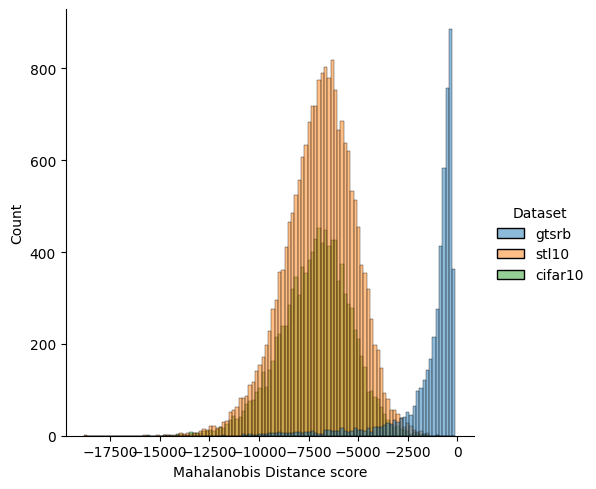

In [140]:
df_pred_h_scores = pd.concat([df_m_dist_scores_gtsrb,
                              # df_m_dist_scores_gtsrb_anomal,
                              df_m_dist_scores_stl10,
                              df_m_dist_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Mahalanobis Distance score", hue="Dataset", kind="hist", fill=True)
plt.show()

In [ ]:
ic(ind_gtsrb_m_dist_score.shape);
ic(ood_gtsrb_anomal_m_dist_score.shape);
ic(ood_cifar10_m_dist_score.shape);
ic(ood_stl10_m_dist_score.shape);

### GTSRB vs GTSRB-Anomalies

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [145]:
print("Test InD shape", ind_gtsrb_m_dist_score.shape);
print("Test OoD shape", ood_gtsrb_anomal_m_dist_score.shape);

results_m_dist_gtsrb_anomaly = get_hz_detector_results(detect_exp_name="Mahalanobis Distance score: gtsrb vs. gtsrb_anomaly",
                                                       ind_samples_scores=ind_gtsrb_m_dist_score,
                                                       ood_samples_scores=ood_gtsrb_anomal_m_dist_score)

Test InD shape (4882,)
Test OoD shape (4882,)
AUROC: 0.8830
FPR95: 0.4048
AUPR: 0.8590


### GTSRB vs CIFAR-10

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [146]:
print("Test InD shape", ind_gtsrb_m_dist_score.shape);
print("Test OoD shape", ood_cifar10_m_dist_score.shape);

results_m_dist_cifar10 = get_hz_detector_results(detect_exp_name="Mahalanobis Distance score: gtsrb vs. cifar10",
                                                 ind_samples_scores=ind_gtsrb_m_dist_score,
                                                 ood_samples_scores=ood_cifar10_m_dist_score)

Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.9682
FPR95: 0.1498
AUPR: 0.9573


### GTSRB vs STL-10

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [147]:
print("Test InD shape", ind_gtsrb_m_dist_score.shape);
print("Test OoD shape", ood_stl10_m_dist_score.shape);

results_m_dist_stl10 = get_hz_detector_results(detect_exp_name="Mahalanobis Distance score: gtsrb vs. stl10",
                                                 ind_samples_scores=ind_gtsrb_m_dist_score,
                                                 ood_samples_scores=ood_stl10_m_dist_score)

Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.9708
FPR95: 0.1149
AUPR: 0.9698


## KNN Distance Score

In [54]:
import faiss

In [55]:
class Hook:
    """
    Hook class that returns the input and output of a layer during forward/backward pass
    """
    def __init__(self, module: torch.nn.Module, backward: bool = False):
        """
        Hook Class constructor
        :param module: Layer block from Neural Network Module
        :type module: torch.nn.Module
        :param backward: backward-poss hook
        :type backward: bool
        """
        self.input = None
        self.output = None
        if not backward:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output

    def close(self):
        self.hook.remove()

In [56]:
normalizer = lambda x: x / (np.linalg.norm(x, ord=2, axis=-1, keepdims=True) + 1e-10)


In [73]:
class KNNPostprocessor:
    def __init__(self,
                 K: int = 50,
                 setup_flag: bool = False):
        self.K = K
        self.activation_log = None
        self.setup_flag = setup_flag
        self.index = None

    def setup(self,
              dnn_model: nn.Module,
              ind_dataloader,
              layer_hook,
              get_2d_rep_mean: bool = False):

        if not self.setup_flag:
            print('\n Get latent embeddings z from training set...')
            activation_log = []
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            dnn_model.to(device)
            
            with torch.no_grad():
                for i, (image, label) in enumerate(ind_dataloader):
                    image = image.to(device)
                    pred_logits = dnn_model(image)
                    
                    latent_rep = torch.flatten(layer_hook.output, 1)  # latent representation sample
                    # ic(layer_hook.output)
                    activation_log.append(
                        normalizer(latent_rep.data.cpu().numpy()))

            self.activation_log = np.concatenate(activation_log, axis=0)
            self.index = faiss.IndexFlatL2(latent_rep.shape[1])
            self.index.add(self.activation_log)
            self.setup_flag = True
        else:
            pass

    @torch.no_grad()
    def postprocess(self,
                    dnn_model: nn.Module,
                    dataloader: DataLoader,
                    layer_hook):
        
        all_preds = []
        all_kth_dist_score = []
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dnn_model.to(device)
        
        for i, (image, label) in enumerate(dataloader):
            image = image.to(device)
            pred_logits = dnn_model(image)
            # ic(layer_hook.output)
            latent_rep = torch.flatten(layer_hook.output, 1)  # latent representation sample
            
            pred = torch.max(torch.softmax(pred_logits, dim=1), dim=1)
            latent_rep_normed = normalizer(latent_rep.data.cpu().numpy())
            
            D, _ = self.index.search(
                latent_rep_normed,
                self.K)
            kth_dist = -D[:, -1]
            
            all_preds.append(pred[0])
            all_kth_dist_score.append(kth_dist)
            
        all_preds_t = torch.cat(all_preds)
        # all_kth_dist_score_t = torch.cat(all_kth_dist_score)
        all_kth_dist_score_np = np.concatenate(all_kth_dist_score, axis=0)
        
        return all_preds_t, all_kth_dist_score_np

    def set_K_hyperparam(self, hyperparam: int = 50):
        self.K = hyperparam

    def get_K_hyperparam(self):
        return self.K

In [74]:
ic(len(gtsrb_normal_train_loader));
ic(len(gtsrb_normal_valid_loader));
ic(len(gtsrb_normal_test_loader));
ic("========================================")
ic(len(gtsrb_anomal_train_loader));
ic(len(gtsrb_anomal_valid_loader));
ic(len(gtsrb_anomal_test_loader));
ic("========================================")
ic(len(cifar10_train_loader));
ic(len(cifar10_valid_loader));
ic(len(cifar10_test_loader));
ic("========================================")
ic(len(stl10_train_loader));
ic(len(stl10_valid_loader));
ic(len(stl10_test_loader));

ic| len(gtsrb_normal_train_loader): 7120
ic| len(gtsrb_normal_valid_loader): 3609
ic| len(gtsrb_normal_test_loader): 1273
ic| '========================================'


ic| len(gtsrb_anomal_train_loader): 35600
ic| len(gtsrb_anomal_valid_loader): 3609
ic| len(gtsrb_anomal_test_loader): 1273
ic| '========================================'
ic| len(cifar10_train_loader): 40000
ic| len(cifar10_valid_loader): 10000
ic| len(cifar10_test_loader): 10000
ic| '========================================'
ic| len(stl10_train_loader): 2000
ic| len(stl10_valid_loader): 3000
ic| len(stl10_test_loader): 8000


In [60]:
gtsrb_model_avgpool_layer_hook = Hook(gtsrb_det_model.model.avgpool)
gtsrb_model_avgpool_layer_hook

In [75]:
knn_dist_gtsrb = KNNPostprocessor(K=50, setup_flag=False)

In [76]:
knn_dist_gtsrb.setup(gtsrb_det_model.model,
                     gtsrb_normal_train_loader,
                     layer_hook=gtsrb_model_avgpool_layer_hook)


 Get latent embeddings z from training set...


In [77]:
_, ind_gtsrb_valid_kth_dist_score = knn_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                               gtsrb_normal_valid_loader,
                                                               gtsrb_model_avgpool_layer_hook)

In [79]:
_, ind_gtsrb_valid_kth_dist_score = knn_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                               gtsrb_normal_valid_loader,
                                                               gtsrb_model_avgpool_layer_hook)


_, ind_gtsrb_test_kth_dist_score = knn_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                              gtsrb_normal_test_loader,
                                                              gtsrb_model_avgpool_layer_hook)


_, ood_gtsrb_anomal_valid_kth_dist_score = knn_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                                      gtsrb_anomal_valid_loader,
                                                                      gtsrb_model_avgpool_layer_hook)

_, ood_gtsrb_anomal_test_kth_dist_score = knn_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                                     gtsrb_anomal_test_loader,
                                                                     gtsrb_model_avgpool_layer_hook)


_, ood_cifar10_valid_kth_dist_score = knn_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                                 cifar10_valid_loader,
                                                                 gtsrb_model_avgpool_layer_hook)

_, ood_cifar10_test_kth_dist_score = knn_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                                cifar10_test_loader,
                                                                gtsrb_model_avgpool_layer_hook)


_, ood_stl10_valid_kth_dist_score = knn_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                               stl10_valid_loader,
                                                               gtsrb_model_avgpool_layer_hook)

_, ood_stl10_test_kth_dist_score = knn_dist_gtsrb.postprocess(gtsrb_det_model.model,
                                                              stl10_test_loader,
                                                              gtsrb_model_avgpool_layer_hook)

In [80]:
ind_gtsrb_kth_dist_score = np.concatenate((ind_gtsrb_valid_kth_dist_score, ind_gtsrb_test_kth_dist_score))
ood_gtsrb_anomal_kth_dist_score = np.concatenate((ood_gtsrb_anomal_valid_kth_dist_score, ood_gtsrb_anomal_test_kth_dist_score))
ood_cifar10_kth_dist_score = np.concatenate((ood_cifar10_valid_kth_dist_score, ood_cifar10_test_kth_dist_score))
ood_stl10_kth_dist_score = np.concatenate((ood_stl10_valid_kth_dist_score, ood_stl10_test_kth_dist_score))

In [ ]:
knn_dist_score_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/baseline_methods/OoD_detection_baselines/mahalanobis_dist_score/'

In [83]:
np.save(knn_dist_score_path + 'ind_gtsrb_kth_dist_score',
        ind_gtsrb_kth_dist_score)

np.save(knn_dist_score_path + 'ood_gtsrb_anomal_kth_dist_score',
        ood_gtsrb_anomal_kth_dist_score)

np.save(knn_dist_score_path + 'ood_cifar10_kth_dist_score',
        ood_cifar10_kth_dist_score)

np.save(knn_dist_score_path + 'ood_stl10_kth_dist_score',
        ood_stl10_kth_dist_score)

In [84]:
ic(ind_gtsrb_kth_dist_score.shape);
ic(ood_gtsrb_anomal_kth_dist_score.shape);
ic(ood_cifar10_kth_dist_score.shape);
ic(ood_stl10_kth_dist_score.shape);

ic| ind_gtsrb_kth_dist_score.shape: (4882,)
ic| ood_gtsrb_anomal_kth_dist_score.shape: (4882,)
ic| ood_cifar10_kth_dist_score.shape: (20000,)
ic| ood_stl10_kth_dist_score.shape: (11000,)


In [86]:
df_kth_dist_scores_gtsrb = pd.DataFrame(ind_gtsrb_kth_dist_score, columns=["KNN Distance score"])
df_kth_dist_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_kth_dist_score, columns=["KNN Distance score"])
df_kth_dist_scores_stl10 = pd.DataFrame(ood_cifar10_kth_dist_score, columns=["KNN Distance score"])
df_kth_dist_scores_cifar10 = pd.DataFrame(ood_stl10_kth_dist_score, columns=["KNN Distance score"])

df_kth_dist_scores_gtsrb.insert(0, "Dataset", "")
df_kth_dist_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_kth_dist_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_kth_dist_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_kth_dist_scores_stl10.insert(0, "Dataset", "")
df_kth_dist_scores_stl10.loc[:, "Dataset"] = "stl10"

df_kth_dist_scores_cifar10.insert(0, "Dataset", "")
df_kth_dist_scores_cifar10.loc[:, "Dataset"] = "cifar10"

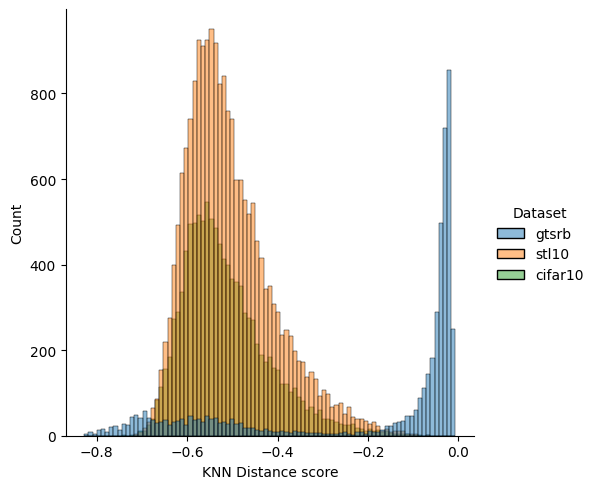

In [99]:
df_pred_kth_dist_scores = pd.concat([df_kth_dist_scores_gtsrb,
                                    #  df_kth_dist_scores_gtsrb_anomal,
                                     df_kth_dist_scores_stl10,
                                     df_kth_dist_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_kth_dist_scores, x="KNN Distance score", hue="Dataset", kind="hist", fill=True)
plt.show()

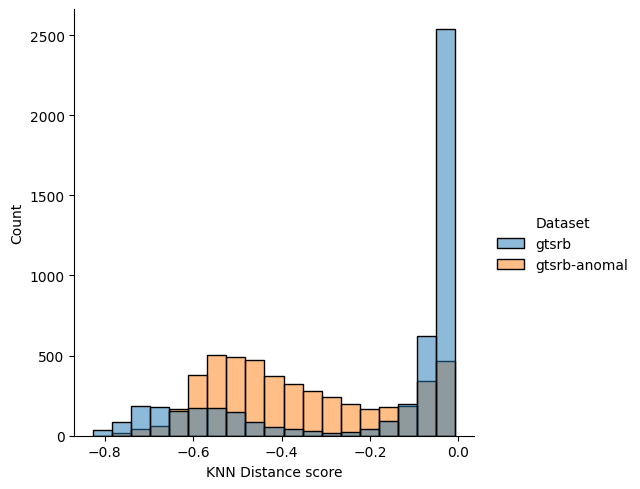

In [98]:
df_pred_kth_dist_scores = pd.concat([df_kth_dist_scores_gtsrb,
                                     df_kth_dist_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_pred_kth_dist_scores, x="KNN Distance score", hue="Dataset", kind="hist", fill=True)
plt.show()

In [89]:
ic(ind_gtsrb_kth_dist_score.shape);
ic(ood_gtsrb_anomal_kth_dist_score.shape);
ic(ood_cifar10_kth_dist_score.shape);
ic(ood_stl10_kth_dist_score.shape);

ic| ind_gtsrb_kth_dist_score.shape: (4882,)
ic| ood_gtsrb_anomal_kth_dist_score.shape: (4882,)
ic| ood_cifar10_kth_dist_score.shape: (20000,)
ic| ood_stl10_kth_dist_score.shape: (11000,)


### GTSRB vs GTSRB-Anomalies

We align with the convention where positive (in-distribution) samples have higher scores (see plots above)

In [93]:
print("Test InD shape", ind_gtsrb_kth_dist_score.shape);
print("Test OoD shape", ood_gtsrb_anomal_kth_dist_score.shape);

results_kth_dist_gtsrb_anomaly = get_hz_detector_results(detect_exp_name="KNN Distance score: gtsrb vs. gtsrb_anomaly",
                                                         ind_samples_scores=ind_gtsrb_kth_dist_score,
                                                         ood_samples_scores=ood_gtsrb_anomal_kth_dist_score)

Test InD shape (4882,)
Test OoD shape (4882,)
AUROC: 0.2863
FPR95: 0.9949
AUPR: 0.4640


### GTSRB vs CIFAR-10

We align with the convention where positive (in-distribution) samples have higher scores (see plots above)

In [96]:
print("Test InD shape", ind_gtsrb_kth_dist_score.shape);
print("Test OoD shape", ood_cifar10_kth_dist_score.shape);

results_kth_dist_cifar10 = get_hz_detector_results(detect_exp_name="KNN Distance score: gtsrb vs. cifar10",
                                                 ind_samples_scores=ind_gtsrb_kth_dist_score,
                                                 ood_samples_scores=ood_cifar10_kth_dist_score)

Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.7993
FPR95: 0.9998
AUPR: 0.7952


### GTSRB vs STL-10

We align with the convention where positive (in-distribution) samples have higher scores (see plots above)

In [92]:
print("Test InD shape", ind_gtsrb_kth_dist_score.shape);
print("Test OoD shape", ood_stl10_kth_dist_score.shape);

results_kth_dist_stl10 = get_hz_detector_results(detect_exp_name="KNN Distance score: gtsrb vs. stl10",
                                                 ind_samples_scores=ind_gtsrb_kth_dist_score,
                                                 ood_samples_scores=ood_stl10_kth_dist_score)

Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.8043
FPR95: 0.9996
AUPR: 0.8318


# Help Computations

In [150]:
a = torch.mean(dl_preds, dim=1)
ic(a.shape);
h = - torch.sum(a * torch.log(a), dim=1)
ic(h.shape);

ic| a.shape: torch.Size([1273, 43])
ic| h.shape: torch.Size([1273])


In [145]:
dl_preds.shape

torch.Size([1273, 4, 43])

In [170]:
b = -torch.sum(dl_preds * torch.log(dl_preds), dim=-1)
b.shape

torch.Size([1273, 4])

In [171]:
c = torch.mean(b, dim=-1)
c.shape

torch.Size([1273])

In [15]:
a = np.arange(9) - 4
a


array([-4, -3, -2, -1,  0,  1,  2,  3,  4])

In [24]:
b = a.reshape((3, 3)).astype(np.float32)
b

array([[-4., -3., -2.],
       [-1.,  0.,  1.],
       [ 2.,  3.,  4.]], dtype=float32)

In [25]:
normalizer = lambda x: x / (np.linalg.norm(x, ord=2, axis=-1, keepdims=True) + 1e-10)

In [26]:
np.linalg.norm(b, ord=2, axis=-1, keepdims=True)

array([[5.3851647],
       [1.4142135],
       [5.3851647]], dtype=float32)

In [27]:
c = normalizer(b)
c

array([[-0.74278134, -0.55708605, -0.37139067],
       [-0.70710677,  0.        ,  0.70710677],
       [ 0.37139067,  0.55708605,  0.74278134]], dtype=float32)

In [28]:
b_t = torch.from_numpy(b, )
b_t

tensor([[-4., -3., -2.],
        [-1.,  0.,  1.],
        [ 2.,  3.,  4.]])

In [30]:
c_t = torch.nn.functional.normalize(b_t)
c_t

tensor([[-0.7428, -0.5571, -0.3714],
        [-0.7071,  0.0000,  0.7071],
        [ 0.3714,  0.5571,  0.7428]])

In [31]:
z = torch.randn((1, 3))
z

tensor([[0.2152, 0.3962, 1.6234]])

In [33]:
z_norm = torch.nn.functional.normalize(z)
z_norm

tensor([[0.1278, 0.2352, 0.9635]])